In [1]:
# std lib
from getpass import getpass

# 3rd party
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from astropy.utils.data import download_file  #import file from URL
from scipy.stats import binned_statistic_2d
%matplotlib inline
from astropy.table import Table

# Data Lab
from dl import authClient as ac, queryClient as qc, storeClient as sc
from dl.helpers.utils import convert

print('Done importing')

Done importing


In [2]:
token = ac.login(input("Enter user name: (+ENTER) "),getpass("Enter password: (+ENTER) "))

Enter user name: (+ENTER) yuxinhuang
Enter password: (+ENTER) ········


In [2]:
ac.whoAmI()

'yuxinhuang'

In [5]:
print(qc.schema('des_dr1'))


Schema: des_dr1

      Table Name   Description
      ----------   -----------
     des_allwise   ALLWISE 1-arcsec xmatch v. DES
       des_gaia2   Gaia DR2 1.5-arcsec xmatch v. DES
       des_galex   GALEX (AIS) 1-arcsec xmatch v. DES
        des_hsc2   HSC2 1-arcsec xmatch v. DES
      des_nscdr1   NSC DR1 1.5-arcsec xmatch v. DES
      des_simbad   SIMBAD 1-arcsec xmatch v. DES
            flux   Object flux table
       img2coadd   Images contributing to coadded tiles
             mag   Object magnitude table
            main   Main object table
       neighbors   Neighbors w/in 30-arcsec of each object
       tile_info   Survey tile information table
  x_gaia_dr2_2p5   Gaia DR1 2.5 arcsec xmatch v. DES



In [8]:
print(qc.schema('des_dr1.main'))


Schema: des_dr1
 Table: main

     Column Name   Description
     -----------   -----------
 coadd_object_id   Unique identifier for the coadded objects
         hpix_32   Healpix ID for nside=32, nested schema
         hpix_64   Healpix ID for nside=64, nested schema
       hpix_1024   Healpix ID for nside=1024, nested schema
       hpix_4096   Healpix ID for nside=4096, nested schema
      hpix_16384   Healpix ID for nside=16384, nested schema
              ra   Right ascension, with quantized precision for indexing (AL
                   PHAWIN_J2000 has full precision but not indexed)
             dec   Declination, with quantized precision for indexing (DELTAW
                   IN_J2000 has full precision but not indexed)
  alphawin_j2000   Right ascension for the object, J2000 in ICRS system (full
                   precision but not indexed)
  deltawin_j2000   Declination for the object, J2000 in ICRS (full precision 
                   but not indexed)
      galactic_l   Gala

In [3]:
RA180924 = (21 + 44/60 + 25/3600)/24*360
RA191001 = (21 + 33/60 + 24/3600)/24*360
RA181112 = (21 + 49/60 + 23/3600)/24*360

DEC180924 = - (40 + 54/60)
DEC191001 = - (54 + 44/60 + 54/3600)
DEC181112 = - (52 + 58/60 + 15/3600)

In [4]:
print(RA180924, DEC180924)
print(RA191001, DEC191001)
print(RA181112, DEC181112)

326.1041666666667 -40.9
323.35 -54.748333333333335
327.3458333333333 -52.97083333333334


In [17]:
# Write query statement (sql) as a string
# NOTE: triple quotes allow us to break the string on multiple lines
query = """
        SELECT  mag_aper_8_r as rmag_aper, mag_auto_g as gmag, mag_auto_r as rmag, mag_auto_z as zmag, 
               mag_auto_i as imag, mag_auto_y as ymag, 
               class_star_g, class_star_r, class_star_z, 
               snr_g, snr_r, snr_z, ra, dec
        FROM des_dr1.main 
        WHERE (ra-(326.104)<1 and ra-(326.104)>-1 and dec-(-40.9)<1 and dec-(-40.9)>-1
                and snr_g>5 and snr_r>5 and snr_z>5 
                and class_star_r<0.5 and class_star_g<0.5 and class_star_z<0.5
                and mag_aper_8_r<20.65)
        LIMIT 50000"""

# mag_auto_g,r,i,z,y = AB magnitudes in DECam g,r,i,z,y bands
# class_star_g,r,z   = star/extended source classifier (from 0 to 1)
# snr_g,r,z          = computed signal-to-noise ratios (S/N) in g,r,z bands
# ra,dec             = celestial coordinates

print(query)


        SELECT  mag_aper_8_r as rmag_aper, mag_auto_g as gmag, mag_auto_r as rmag, mag_auto_z as zmag, 
               mag_auto_i as imag, mag_auto_y as ymag, 
               class_star_g, class_star_r, class_star_z, 
               snr_g, snr_r, snr_z, ra, dec
        FROM des_dr1.main 
        WHERE (ra-(326.104)<1 and ra-(326.104)>-1 and dec-(-40.9)<1 and dec-(-40.9)>-1
                and snr_g>5 and snr_r>5 and snr_z>5 
                and class_star_r<0.5 and class_star_g<0.5 and class_star_z<0.5
                and mag_aper_8_r<20.65)
        LIMIT 5


In [44]:
# Write query statement (sql) as a string
# NOTE: triple quotes allow us to break the string on multiple lines
query = """
        SELECT  mag_auto_r as rmag, mag_aper_8_r as rmag_aper,
               class_star_g, class_star_r, class_star_z, 
               snr_g, snr_r, snr_z, ra, dec
        FROM des_dr1.main 
        WHERE (ra-(326.104)<1 and ra-(326.104)>-1 and dec-(-40.9)<1 and dec-(-40.9)>-1
                and snr_g>5 and snr_r>5 and snr_z>5 
                and class_star_r<0.5 and class_star_g<0.5 and class_star_z<0.5
                and mag_aper_8_r<20.65 and mag_aper_8_r>0)
        LIMIT 50000"""

# mag_auto_g,r,i,z,y = AB magnitudes in DECam g,r,i,z,y bands
# class_star_g,r,z   = star/extended source classifier (from 0 to 1)
# snr_g,r,z          = computed signal-to-noise ratios (S/N) in g,r,z bands
# ra,dec             = celestial coordinates

print(query)


        SELECT  mag_auto_r as rmag, mag_aper_8_r as rmag_aper,
               class_star_g, class_star_r, class_star_z, 
               snr_g, snr_r, snr_z, ra, dec
        FROM des_dr1.main 
        WHERE (ra-(326.104)<1 and ra-(326.104)>-1 and dec-(-40.9)<1 and dec-(-40.9)>-1
                and snr_g>5 and snr_r>5 and snr_z>5 
                and class_star_r<0.5 and class_star_g<0.5 and class_star_z<0.5
                and mag_aper_8_r<20.65 and mag_aper_8_r>0)
        LIMIT 50000


In [45]:
%%time
# Execute the query synchronously, if short (e.g., LIMIT<=300,000)
# We then convert the returned result, a CSV-formatted string, to a Pandas data frame,
# making sure that any potential 'Infinity' values are converted to NaN.
res = qc.query(sql=query)
df = convert(res,'pandas')

CPU times: user 53 ms, sys: 11 ms, total: 64 ms
Wall time: 4min 48s


In [46]:
print(df[5:])
len(df)

         rmag  rmag_aper  class_star_g  class_star_r  class_star_z     snr_g  \
5     18.7714    18.8284      0.026190      0.028707      0.028686   60.1891   
6     20.0409    20.1031      0.010559      0.022634      0.000609   40.9685   
7     18.4655    18.6157      0.026080      0.028592      0.028543   96.2588   
8     20.3273    20.2811      0.104126      0.058931      0.032837   16.9555   
9     17.9829    18.4731      0.023315      0.028592      0.028308  116.9530   
...       ...        ...           ...           ...           ...       ...   
7678  19.3585    19.4105      0.028155      0.028688      0.028424  120.8460   
7679  20.1059    20.0948      0.028000      0.028590      0.026422   86.0858   
7680  19.9630    19.9771      0.020624      0.028594      0.028450   52.3225   
7681  20.6360    20.6405      0.004007      0.027547      0.027629   25.9689   
7682  18.5068    18.8937      0.027733      0.028660      0.028640  133.2140   

         snr_r     snr_z          ra   

7683

In [47]:
ra = df['ra'][:]
dec = df['dec'][:]
rmag = df['rmag'][:]
rmag_aper = df['rmag_aper'][:]

In [48]:
print(max(abs(rmag - rmag_aper)), min(abs(rmag - rmag_aper)))

2.3613999999999997 0.0


Text(0, 0.5, 'rmag_aper')

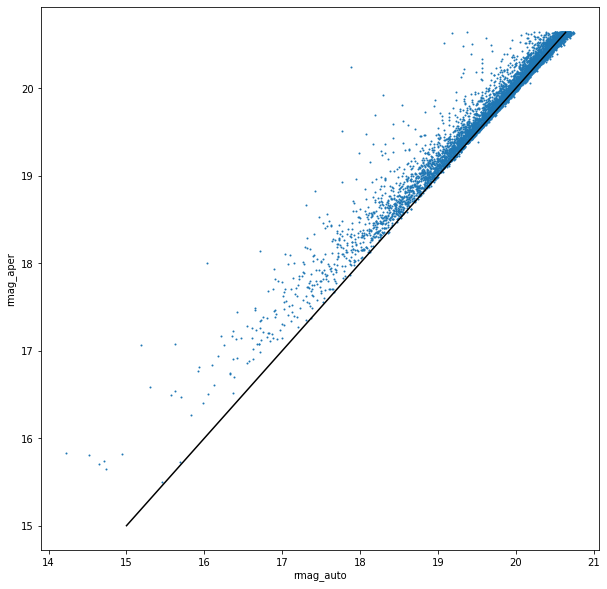

In [49]:
plt.figure(figsize=(10,10))
plt.scatter(rmag, rmag_aper,s=1)
x = np.arange(15,20.65,0.01)
y = x
plt.plot(x,y,color='black')
plt.xlabel('rmag_auto')
plt.ylabel('rmag_aper')

In [58]:
ra = df['ra'][:]
dec = df['dec'][:]
rmag = df['rmag'][:]
rmag_aper = df['rmag_aper'][:]
#iin = np.where((rmag<19.8)*(ra-(326.104)<0.5)*(ra-(326.104)>-0.5)*(dec-(-40.9)<0.5)*(dec-(-40.9)>-0.5))
iin = np.where((rmag_aper<20.649))
ra = np.array(ra)[iin]
dec = np.array(dec)[iin]
rmag = np.array(rmag)[iin]
rmag_aper = np.array(rmag_aper)[iin]

len(ra)

7672

19.79953956604 15.1862192153931


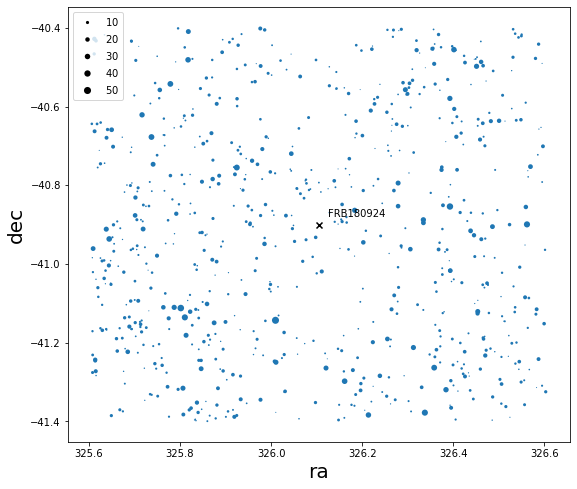

In [78]:
col0 = ra   #ra
col1 = dec   #dec

# 2D-histogram of objects
fig, ax1 = plt.subplots(1, 1, figsize=(9, 8))
im1 = ax1.scatter(col0, col1, marker='o', s = -(50-1)/(max(rmag)-min(rmag)) * rmag + ((50-1)/(max(rmag)-min(rmag)) * max(rmag)+1), lw=0)
ax1.scatter(RA180924,DEC180924, marker='x', color='black')
ax1.annotate('FRB180924', xy = (RA180924,DEC180924),xytext = (RA180924+0.02,DEC180924+0.02))
ax1.set_xlabel('ra',fontsize=20)
ax1.set_ylabel('dec',fontsize=20)
ax1.legend(*im1.legend_elements("sizes", num=5))

print(max(rmag),min(rmag))

#plt.savefig('frb180924_auto_19.8_1df_753.png')

19.8435 15.5017


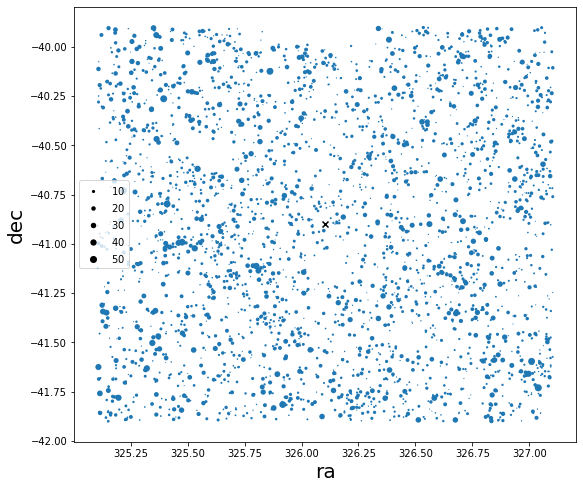

In [54]:
col0 = ra   #ra
col1 = dec   #dec

# 2D-histogram of objects
fig, ax1 = plt.subplots(1, 1, figsize=(9, 8))
im1 = ax1.scatter(col0, col1, marker='o', s = -(50-1)/(max(rmag_aper)-min(rmag_aper)) * rmag_aper + ((50-1)/(max(rmag_aper)-min(rmag_aper)) * max(rmag_aper)+1), lw=0)
ax1.scatter(RA180924,DEC180924, marker='x', color='black')
#ax1.annotate('FRB180924', xy = (RA180924,DEC180924),xytext = (RA180924+0.02,DEC180924+0.02))
ax1.set_xlabel('ra',fontsize=20)
ax1.set_ylabel('dec',fontsize=20)
ax1.legend(*im1.legend_elements("sizes", num=5))

print(max(rmag_aper),min(rmag_aper))

#plt.savefig('frb180924_aper_19.844_2df_2934.png')


In [ ]:
FRB191001 323.35 -54.748333333333335

In [59]:
# Write query statement (sql) as a string
# NOTE: triple quotes allow us to break the string on multiple lines
query = """
        SELECT mag_auto_r as rmag, mag_aper_8_r as rmag_aper, 
               class_star_g, class_star_r, class_star_z, 
               snr_g, snr_r, snr_z, ra, dec
        FROM des_dr1.main 
        WHERE (ra-(323.35)<1 and ra-(323.35)>-1 and dec-(-54.75)<1 and dec-(-54.75)>-1
                and snr_g>5 and snr_r>5 and snr_z>5 
                and class_star_r<0.5 and class_star_g<0.5 and class_star_z<0.5
                and mag_aper_8_r<20.65 and mag_aper_8_r>0)
        LIMIT 50000"""

# mag_auto_g,r,i,z,y = AB magnitudes in DECam g,r,i,z,y bands
# class_star_g,r,z   = star/extended source classifier (from 0 to 1)
# snr_g,r,z          = computed signal-to-noise ratios (S/N) in g,r,z bands
# ra,dec             = celestial coordinates

print(query)


        SELECT mag_auto_r as rmag, mag_aper_8_r as rmag_aper, 
               class_star_g, class_star_r, class_star_z, 
               snr_g, snr_r, snr_z, ra, dec
        FROM des_dr1.main 
        WHERE (ra-(323.35)<1 and ra-(323.35)>-1 and dec-(-54.75)<1 and dec-(-54.75)>-1
                and snr_g>5 and snr_r>5 and snr_z>5 
                and class_star_r<0.5 and class_star_g<0.5 and class_star_z<0.5
                and mag_aper_8_r<20.65 and mag_aper_8_r>0)
        LIMIT 50000


In [60]:
%%time
# Execute the query synchronously, if short (e.g., LIMIT<=300,000)
# We then convert the returned result, a CSV-formatted string, to a Pandas data frame,
# making sure that any potential 'Infinity' values are converted to NaN.
res1 = qc.query(sql=query)
df1 = convert(res1,'pandas')

CPU times: user 57 ms, sys: 9 ms, total: 66 ms
Wall time: 4min 59s


In [61]:
print(df1[:5])
len(df1)

      rmag  rmag_aper  class_star_g  class_star_r  class_star_z     snr_g  \
0  20.2655    20.2564      0.017168      0.028788      0.031800   37.4840   
1  17.9946    18.2547      0.029059      0.028651      0.028620  313.5380   
2  19.1466    19.3123      0.026370      0.028654      0.028651   81.1797   
3  19.8559    20.0624      0.023921      0.025935      0.000406   73.6008   
4  19.7480    19.8442      0.023707      0.028572      0.028561   67.9234   

      snr_r     snr_z          ra        dec  
0  100.7260   81.3369  322.386533 -55.702807  
1  461.0920  272.8520  322.396386 -55.747500  
2  175.7230  121.3060  322.376804 -55.678237  
3   80.9969   42.2072  322.357023 -55.573208  
4  150.3260  108.9940  322.364526 -55.711653  


6036

In [65]:
ra = df1['ra'][:]
dec = df1['dec'][:]
rmag = df1['rmag'][:]
rmag_aper = df1['rmag_aper'][:]
#iin = np.where((rmag<19.4)*(ra-(323.35)<0.5)*(ra-(323.35)>-0.5)*(dec-(-54.75)<0.5)*(dec-(-54.75)>-0.5))
iin = np.where((rmag_aper<19.466))
ra = np.array(ra)[iin]
dec = np.array(dec)[iin]
rmag = np.array(rmag)[iin]
rmag_aper = np.array(rmag_aper)[iin]

len(ra)

1588

19.3995742797852 14.933614730834998


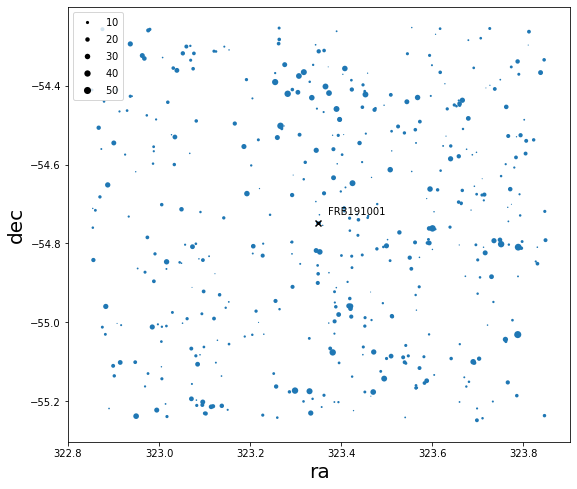

In [84]:
col0 = ra   #ra
col1 = dec   #dec

# 2D-histogram of objects
fig, ax1 = plt.subplots(1, 1, figsize=(9, 8))
im1 = ax1.scatter(col0, col1, marker='o', s = -(50-1)/(max(rmag)-min(rmag)) * rmag + ((50-1)/(max(rmag)-min(rmag)) * max(rmag)+1), lw=0)
ax1.scatter(RA191001,DEC191001, marker='x', color='black')
ax1.annotate('FRB191001', xy = (RA191001,DEC191001),xytext = (RA191001+0.02,DEC191001+0.02))
ax1.set_xlabel('ra',fontsize=20)
ax1.set_ylabel('dec',fontsize=20)
ax1.legend(*im1.legend_elements("sizes", num=5))

print(max(rmag),min(rmag))

#plt.savefig('frb191001_auto_19.4_1df_464.png')

19.4656 15.5366


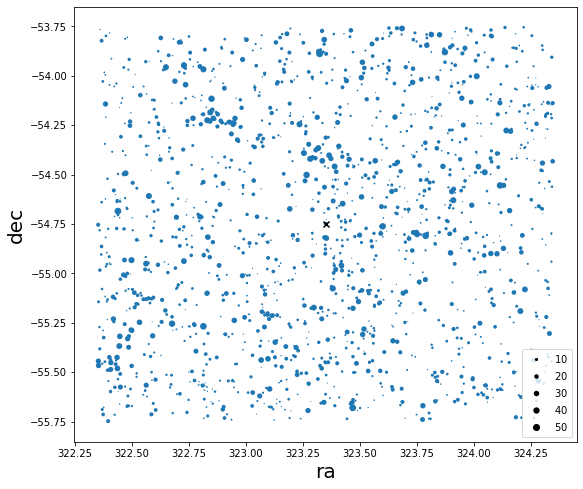

In [68]:
col0 = ra   #ra
col1 = dec   #dec

# 2D-histogram of objects
fig, ax1 = plt.subplots(1, 1, figsize=(9, 8))
im1 = ax1.scatter(col0, col1, marker='o', s = -(50-1)/(max(rmag_aper)-min(rmag_aper)) * rmag_aper + ((50-1)/(max(rmag_aper)-min(rmag_aper)) * max(rmag_aper)+1), lw=0)
ax1.scatter(RA191001,DEC191001, marker='x', color='black')
#ax1.annotate('FRB191001', xy = (RA191001,DEC191001),xytext = (RA191001+0.02,DEC191001+0.02))
ax1.set_xlabel('ra',fontsize=20)
ax1.set_ylabel('dec',fontsize=20)
ax1.legend(*im1.legend_elements("sizes", num=5))

print(max(rmag_aper),min(rmag_aper))

#plt.savefig('frb191001_aper_19.466_2df_1588.png')

In [86]:
print(RA181112, DEC181112)

327.3458333333333 -52.97083333333334


In [ ]:
# Write query statement (sql) as a string
# NOTE: triple quotes allow us to break the string on multiple lines
query = """
        SELECT mag_auto_r as rmag, mag_aper_8_r as rmag_aper, 
               class_star_g, class_star_r, class_star_z, 
               snr_g, snr_r, snr_z, ra, dec
        FROM des_dr1.main 
        WHERE (ra-(327.346)<1 and ra-(327.346)>-1 and dec-(-52.971)<1 and dec-(-52.971)>-1
                and snr_g>5 and snr_r>5 and snr_z>5 
                and class_star_r<0.5 and class_star_g<0.5 and class_star_z<0.5
                and mag_aper_8_r<20.65 and mag_aper_8_r>0 and mag_auto_r>0 and mag_auto_r<30)
        LIMIT 50000"""

# mag_auto_g,r,i,z,y = AB magnitudes in DECam g,r,i,z,y bands
# class_star_g,r,z   = star/extended source classifier (from 0 to 1)
# snr_g,r,z          = computed signal-to-noise ratios (S/N) in g,r,z bands
# ra,dec             = celestial coordinates

print(query)

In [78]:
%%time
# Execute the query synchronously, if short (e.g., LIMIT<=300,000)
# We then convert the returned result, a CSV-formatted string, to a Pandas data frame,
# making sure that any potential 'Infinity' values are converted to NaN.
res2 = qc.query(sql=query)
df2 = convert(res2,'pandas')

ReadTimeout: HTTPSConnectionPool(host='datalab.noao.edu', port=443): Read timed out. (read timeout=300)

In [106]:
ra = df2['ra'][:]
dec = df2['dec'][:]
rmag = df2['rmag'][:]
rmag_aper = df2['rmag_aper'][:]
#iin = np.where((rmag<20.6)*(ra-(327.346)<0.5)*(ra-(327.346)>-0.5)*(dec-(-52.971)<0.5)*(dec-(-52.971)>-0.5))
iin = np.where((rmag_aper<19.466))
ra = np.array(ra)[iin]
dec = np.array(dec)[iin]
rmag = np.array(rmag)[iin]
rmag_aper = np.array(rmag_aper)[iin]

len(ra)

1250

20.5991497039795 13.600948333740199


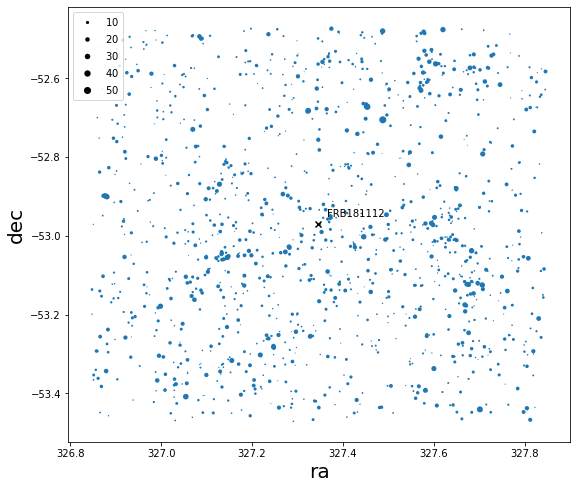

In [109]:
col0 = ra   #ra
col1 = dec   #dec

# 2D-histogram of objects
fig, ax1 = plt.subplots(1, 1, figsize=(9, 8))
im1 = ax1.scatter(col0, col1, marker='o', s = -(50-1)/(max(rmag)-min(rmag)) * rmag + ((50-1)/(max(rmag)-min(rmag)) * max(rmag)+1), lw=0)
ax1.scatter(RA181112,DEC181112, marker='x', color='black')
ax1.annotate('FRB181112', xy = (RA181112,DEC181112),xytext = (RA181112+0.02,DEC181112+0.02))
ax1.set_xlabel('ra',fontsize=20)
ax1.set_ylabel('dec',fontsize=20)
ax1.legend(*im1.legend_elements("sizes", num=5))

print(max(rmag),min(rmag))

plt.savefig('frb181112_auto_20.6_1df_1250.png')

21.7195682525635 14.944062232971199


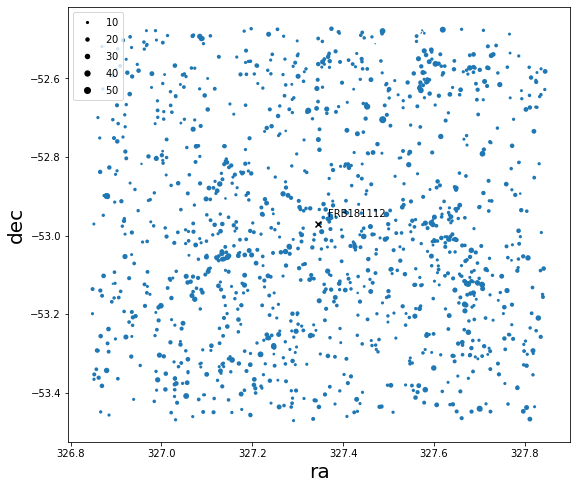

In [111]:
col0 = ra   #ra
col1 = dec   #dec

# 2D-histogram of objects
fig, ax1 = plt.subplots(1, 1, figsize=(9, 8))
im1 = ax1.scatter(col0, col1, marker='o', s = -(50-1)/(max(rmag_aper)-min(rmag_aper)) * rmag_aper + ((50-1)/(max(rmag_aper)-min(rmag_aper)) * max(rmag_aper)+1), lw=0)
ax1.scatter(RA181112,DEC181112, marker='x', color='black')
ax1.annotate('FRB181112', xy = (RA181112,DEC181112),xytext = (RA181112+0.02,DEC181112+0.02))
ax1.set_xlabel('ra',fontsize=20)
ax1.set_ylabel('dec',fontsize=20)
ax1.legend(*im1.legend_elements("sizes", num=5))

print(max(rmag_aper),min(rmag_aper))

plt.savefig('frb181112_aper_20.6_1df_1250.png')